<!DOCTYPE HTML>

<html lang="ja">
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<script async="" src="https://www.googletagmanager.com/gtag/js?id=G-88V6DV46SV"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());
  gtag('config', 'G-88V6DV46SV');
</script>
<meta content="クラブユース、高校・大学サッカーからＪリーグ、アジア・欧州チャンピオンズリーグ、アジア杯、EURO、ワールドカップまで網羅した出場記録データベース。各大会の試合結果やランキングを、選手、チーム、監督、審判などの切り口からまとめています" name="description"/>
<meta content="クラブユース、高校・大学サッカーからＪリーグ、アジア・欧州チャンピオンズリーグ、アジア杯、EURO、ワールドカップまで網羅した出場記録データベース。各大会の試合結果やランキングを、選手、チーム、監督、審判などの切り口からまとめています" property="og:description">
<meta content="" name="keywords"/>
<meta content="width=950" name="viewport"/>
<title>Soccer D.B. : 対戦一覧[対戦成績] 川崎フロンターレ vs 浦和レッズ</title>
<meta content="Soccer D.B. " property="og:site_name">
<meta content="対戦一覧[対戦成績] 川崎フロンターレ vs 浦和レッズ" property="og:title">
<meta content="https://soccer-db.net/compare/h2h/1015/100
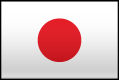
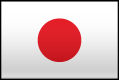

In [1]:
from typing import List, Dict, Union
import json
import pandas as pd
import requests
from bs4 import BeautifulSoup

# 対戦成績のページURL (例: Soccer D.B.の川崎 vs 浦和の対戦ページ)
URL = "https://soccer-db.net/compare/h2h/1015/1008"

# HTTPリクエストを送信
response = requests.get(URL)
response.raise_for_status()  # HTTPエラーがあれば例外を発生

# BeautifulSoupでHTMLを解析
soup = BeautifulSoup(response.text, "html.parser")

soup

In [ ]:
def read_game(table: BeautifulSoup) -> List[Dict[str, Union[str, int, None]]]:
    """
    Soccer D.B.の対戦成績ページにある <table class="box_table_1"> から試合データを取得

    Args:
        table: <table class="box_table_1"> の要素

    Returns:
        試合データのリスト
    """
    rows = table.find_all("tr")
    match_data = []
    previous_match = None  # 直前の試合データを保存

    for row in rows:
        comp_row = row.find("td", colspan="9")
        if comp_row:  # 大会名の更新
            current_competition = comp_row.text.strip()

        if "result_shot" in row.get("class", []):  # シュート数・観客数の取得
            process_result_shot(row, previous_match)

        if "result_card" in row.get("class", []):  # カード数・審判情報の取得
            process_result_card(row, previous_match)

        cols = row.find_all("td")
        if len(cols) >= 10 and "result_score" in str(row):  # 試合データ
            match_info = make_match_info(current_competition, cols)
            match_data.append(match_info)
            previous_match = match_info  # 直前の試合データを更新

    return match_data

def make_match_info(current_competition: str, cols: List[BeautifulSoup]) -> Dict[str, Union[str, int, None]]:
    """
    <td> の行に含まれる試合情報を取得
    """
    match_info = {
                "date": cols[0].text.strip(),  # 試合日
                "competition": current_competition,  # 大会名
                "team1": cols[1].text.strip(),  # ホームチーム
                "score1": cols[3].text.strip(),  # ホーム得点
                "score2": cols[5].text.strip(),  # アウェイ得点
                "team2": cols[7].text.strip(),  # アウェイチーム
                "result_url": cols[4].find("a")["href"] if cols[4].find("a") else None,  # 詳細URL
                "attendance": None,  # 観客数
                "shots_team1": None,  # ホームのシュート数
                "shots_team2": None,  # アウェイのシュート数
                "yellow_cards_team1": 0,  # ホームのイエローカード数
                "yellow_cards_team2": 0,  # アウェイのイエローカード数
                "red_cards_team1": 0,  # ホームのレッドカード数
                "red_cards_team2": 0,  # アウェイのレッドカード数
                "referee": None,  # 主審
            }
    
    return match_info

def process_result_shot(row: BeautifulSoup, previous_match: Dict[str, Union[str, int, None]]) -> None:
    """
    <td class="result_shot"> の行に含まれる観客数とシュート数を取得して直前の試合データに追加
    """
    if previous_match:
        # 観客数
        attendance_td = row.find("td", class_="result_spe")
        if attendance_td and "観客:" in attendance_td.text:
            # 数値以上の情報が含まれる懸念を考慮し、intにはしない
            previous_match["attendance"] = attendance_td.text.strip().replace("観客:", "").replace(",", "")

        # シュート数
        shot_right = len(row.find_all("em", class_="result_sh_r"))  # ホームチームのシュート数
        shot_left = len(row.find_all("em", class_="result_sh_l"))  # アウェイチームのシュート数
        previous_match["shots_team1"] = shot_right
        previous_match["shots_team2"] = shot_left


def process_result_card(row: BeautifulSoup, previous_match: Dict[str, Union[str, int, None]]) -> None:
    """
    <td class="result_card"> の行に含まれるカード数と審判情報を取得して直前の試合データに追加
    """

    if "result_card" in row.get("class", []):
        # ホームとアウェイのカード数を取得
        yellow_right = len(row.find_all("em", class_="result_yc_r"))  # ホームのイエローカード
        red_right = len(row.find_all("em", class_="result_rc_r"))  # ホームのレッドカード
        yellow_left = len(row.find_all("em", class_="result_yc_l"))  # アウェイのイエローカード
        red_left = len(row.find_all("em", class_="result_rc_l"))  # アウェイのレッドカード

        # ホーム or アウェイのカードの更新
        if previous_match and any([yellow_right, red_right, yellow_left, red_left]):
            previous_match["yellow_cards_team1"] += yellow_right
            previous_match["yellow_cards_team2"] += yellow_left
            previous_match["red_cards_team1"] += red_right
            previous_match["red_cards_team2"] += red_left

        # 審判情報の取得
        if "Referee:" in row.text:
            referee_td = row.find("td", class_="l smaller")
            if referee_td and previous_match:
                previous_match["referee"] = referee_td.text.strip()


def read_all_games(soup: BeautifulSoup) -> List[Dict[str, Union[str, int, None]]]:
    """
    対戦成績ページから全ての試合データを取得
    """
    box_tables = soup.find_all("table", {"class": "box_table_1"})
    match_data = []
    for table in box_tables:
        match_data.extend(read_game(table))

    return match_data


match_data = read_all_games(soup)
# JSONに変換
json_output = json.dumps(match_data, indent=2, ensure_ascii=False)

# 結果の表示
print(json_output)


[
  {
    "date": "2000.04.12",
    "competition": "ＪリーグYBCルヴァンカップ  1st Round",
    "team1": "川崎フロンターレ",
    "score1": "3",
    "score2": "0",
    "team2": "浦和レッズ",
    "result_url": "https://soccer-db.net/result/20000412006",
    "attendance": "7026",
    "shots_team1": 23,
    "shots_team2": 11,
    "yellow_cards_team1": 1,
    "yellow_cards_team2": 2,
    "red_cards_team1": 0,
    "red_cards_team2": 0,
    "referee": "ウィウソン デ ソウザ"
  },
  {
    "date": "2000.04.19",
    "competition": "ＪリーグYBCルヴァンカップ  1st Round",
    "team1": "浦和レッズ",
    "score1": "2",
    "score2": "1",
    "team2": "川崎フロンターレ",
    "result_url": "https://soccer-db.net/result/20000419010",
    "attendance": "10763",
    "shots_team1": 11,
    "shots_team2": 12,
    "yellow_cards_team1": 4,
    "yellow_cards_team2": 1,
    "red_cards_team1": 0,
    "red_cards_team2": 0,
    "referee": "上川 徹"
  },
  {
    "date": "2005.03.12",
    "competition": "明治安田 Ｊ１リーグ",
    "team1": "川崎フロンターレ",
    "score1": "3",
    "score2": "

In [10]:
df = pd.DataFrame(match_data)
df

,date,competition,team1,score1,score2,team2,result_url,attendance,shots_team1,shots_team2,yellow_cards_team1,yellow_cards_team2,red_cards_team1,red_cards_team2,referee
0,2000.04.12,ＪリーグYBCルヴァンカップ 1st Round,川崎フロンターレ,3,0,浦和レッズ,https://soccer-db.net/result/20000412006,7026,23,11,1,2,0,0,ウィウソン デ ソウザ
1,2000.04.19,ＪリーグYBCルヴァンカップ 1st Round,浦和レッズ,2,1,川崎フロンターレ,https://soccer-db.net/result/20000419010,10763,11,12,4,1,0,0,上川 徹
2,2005.03.12,明治安田 Ｊ１リーグ,川崎フロンターレ,3,3,浦和レッズ,https://soccer-db.net/result/20050312004,24332,13,15,2,2,0,0,穴沢 努
3,2005.10.29,明治安田 Ｊ１リーグ,浦和レッズ,3,2,川崎フロンターレ,https://soccer-db.net/result/20051029001,37593,14,10,5,5,0,1,家本 政明
4,2005.12.24,天皇杯 JFA 全日本サッカー選手権 Quarter Final,浦和レッズ,2,0,川崎フロンターレ,https://soccer-db.net/result/20051224022,27589,12,12,0,5,0,1,吉田 寿光
5,2006.06.03,ＪリーグYBCルヴァンカップ Quarter Final,浦和レッズ,4,3,川崎フロンターレ,https://soccer-db.net/result/20060603004,19292,12,16,3,2,0,0,奥谷 彰男
6,2006.06.07,ＪリーグYBCルヴァンカップ Quarter Final,川崎フロンターレ,2,1,浦和レッズ,https://soccer-db.net/result/20060607007,16342,13,10,4,3,0,0,西村 雄一
7,2006.07.22,明治安田 Ｊ１リーグ,川崎フロンターレ,0,2,浦和レッズ,https://soccer-db.net/result/20060722004,23005,16,9,2,5,0,1,柏原 丈二
8,2006.10.21,明治安田 Ｊ１リーグ,浦和レッズ,2,2,川崎フロンターレ,https://soccer-db.net/result/20061021007,50134,13,19,4,0,0,0,片山 義継
9,2007.04.21,明治安田 Ｊ１リーグ,浦和レッズ,1,2,川崎フロンターレ,https://soccer-db.net/result/20070421002,50531,18,7,3,2,0,0,吉田 寿光


In [18]:
def test_read_game():
    # テスト用のHTMLデータ
    test_html = """
    <table class="box_table_1">
        <tr class="result_card_comp"><td></td>
            <td colspan="9"><a href="https://soccer-db.net/competition/index/1011">ＪリーグYBCルヴァンカップ</a>  1st Round</td>
        </tr>
        <tr>
            <td>2000.04.12</td>
            <td class="longname_r"><a href="https://soccer-db.net/team/index/1015/2000">川崎フロンターレ</a></td>
            <td class="table_icon"></td>
            <td class="result_score">3</td>
            <td class="link_buttom" rowspan="3"><a href="https://soccer-db.net/result/20000412006">Result</a></td>
            <td class="result_score">0</td>
            <td class="table_icon"></td>
            <td class="longname_l"><a href="https://soccer-db.net/team/index/1008/2000">浦和レッズ</a></td>
            <td class="table_icon"></td>
            <td class="table_icon"></td>
        </tr>
        <tr class="result_shot">
            <td class="result_spe" rowspan="2">観客:7,026</td>
            <td colspan="3">
                <em class="result_sh_r">S</em><em class="result_sh_r">S</em><em class="result_sh_r">S</em>
            </td>
            <td colspan="3">
                <em class="result_sh_l">S</em><em class="result_sh_l">S</em>
            </td>
            <td></td><td></td>
        </tr>
        <tr class="result_card">
            <td colspan="3">
                <em class="result_rc_r">R</em>
            </td>
            <td colspan="3">
                <em class="result_yc_l">Y</em><em class="result_yc_l">Y</em>
            </td>
            <td></td><td></td>
        </tr>
        <tr class="result_card">
            <td class="r smaller">Referee:</td>
            <td class="l smaller" colspan="8">
                <a href="https://soccer-db.net/referee/index/368/2000">ウィウソン デ ソウザ</a>
            </td>
        </tr>
    </table>
    """

    # BeautifulSoupでパース
    soup = BeautifulSoup(test_html, "html.parser")
    table = soup.find("table", class_="box_table_1")

    # read_game関数を実行
    result = read_game(table)

    # 期待する結果
    expected_output = [
        {
            "date": "2000.04.12",
            "competition": "ＪリーグYBCルヴァンカップ  1st Round",
            "team1": "川崎フロンターレ",
            "score1": "3",
            "score2": "0",
            "team2": "浦和レッズ",
            "result_url": "https://soccer-db.net/result/20000412006",
            "attendance": "7026",
            "shots_team1": 3,
            "shots_team2": 2,
            "yellow_cards_team1": 0,
            "yellow_cards_team2": 2,
            "red_cards_team1": 1,
            "red_cards_team2": 0,
            "referee": "ウィウソン デ ソウザ"
        }
    ]
    # テスト実行
    test_passed = compare_results(result, expected_output)
    assert test_passed, "Some tests failed!"


def compare_results(result, expected_output):
    if len(result) != len(expected_output):
        print(f"Test failed! Number of matches does not match: Expected {len(expected_output)}, but got {len(result)}")
        return False

    all_pass = True
    for i, (actual, expected) in enumerate(zip(result, expected_output)):
        mismatches = {}
        for key in expected.keys():
            if actual.get(key) != expected[key]:
                mismatches[key] = {"expected": expected[key], "got": actual.get(key)}

        if mismatches:
            print(f"Mismatch found in match {i + 1}:")
            for field, values in mismatches.items():
                print(f"  {field}: Expected {values['expected']}, but got {values['got']}")
            print("-" * 50)
            all_pass = False

    if all_pass:
        print("All tests passed!")
        return True
    else:
        print("Test failed!")
        return False


# テスト実行
test_read_game()


All tests passed!
